In [1]:
import pandas as pd

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

2024-02-06 15:25:53.351252: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-06 15:25:53.897660: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Setup and Configuration

In [2]:
# Alabama data
file = "./ML_Training_01.csv"

# read data into a Pandas dataframe
df = pd.read_csv(file)

# ignore first few columns, which are FIPs codes, not needed for ML
df = df.iloc[:, 3:] 

df = df.rename( columns={"OrnlType":"BuildingType"} )
df.head()

,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,BuildingType
0,-86.452369,32.454446,2168.997509,62660.0,24170.0,2.409557,77,10.0,602.0,3.0,6.0,119.0,residential,Education
1,-86.451701,32.454445,3918.400075,62660.0,24170.0,2.409557,94,10.0,602.0,3.0,6.0,119.0,residential,Education
2,-86.451652,32.453549,501.138397,62660.0,24170.0,2.409557,47,10.0,602.0,3.0,6.0,119.0,residential,Education
3,-86.456148,32.454743,487.162570,62660.0,24170.0,2.409557,56,10.0,602.0,3.0,6.0,119.0,residential,Education
4,-86.451483,32.454827,16.444244,62660.0,24170.0,2.409557,83,10.0,602.0,3.0,6.0,119.0,residential,Education


In [3]:
# classify a building as "Residential", "Commercial", or "Other"
df.loc[df["BuildingType"] == "Industrial", "BuildingType"] = 'Other'
df.loc[df["BuildingType"] == "Assembly", "BuildingType"] = 'Other'
df.loc[df["BuildingType"] == "Education", "BuildingType"] = 'Other'
df.loc[df["BuildingType"] == "Government", "BuildingType"] = 'Other'
df.loc[df["BuildingType"] == "Agriculture", "BuildingType"] = 'Other'
df.loc[df["BuildingType"] == "Utility and Misc", "BuildingType"] = 'Other'

# building type distributions
x = df['BuildingType'].value_counts()
print()
print( x )
print()
print( x[0]/df['BuildingType'].value_counts() )
print()


Residential    2060502
Commercial      136922
Other           110849
Name: BuildingType, dtype: int64

Residential     1.000000
Commercial     15.048728
Other          18.588368
Name: BuildingType, dtype: float64



In [4]:
from sklearn import preprocessing

df = df.sample(frac=1) # shuffle the dataframe (technically, we randomly resample the entire df)

# preprocess the data - scaling
scaler = preprocessing.StandardScaler()
    
columns = ['X', 'Y', 'Area', 'MedianIncomeCounty', 
           'HousingUnitsCounty', 'HousingDensityCounty',
           'Impervious', 'AgCount', 'CmCount', 'GvCount',
           'EdCount', 'InCount']
df[columns] = scaler.fit_transform(df[columns])

df = df.dropna()

nCols = df.shape[1]
le = preprocessing.LabelEncoder()
le.fit( df.iloc[:, nCols-1] ) # ornl type
df.iloc[:, nCols-1] = le.transform( df.iloc[:, nCols-1] )
    
le2 = preprocessing.LabelEncoder()
le2.fit( df.iloc[:, nCols-2] ) # nearest road type
df.iloc[:, nCols-2] = le2.transform( df.iloc[:, nCols-2] )

/tmp/ipykernel_33582/1358776107.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, nCols-1] = le.transform( df.iloc[:, nCols-1] )
/tmp/ipykernel_33582/1358776107.py:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, nCols-2] = le2.transform( df.iloc[:, nCols-2] )


In [5]:
df.head()

,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,BuildingType
1591370,-1.884314,-1.854621,-0.105389,-0.302436,0.989616,0.370678,-1.051383,2.988046,0.781750,1.116229,0.577660,1.041752,4,2
110322,-1.098579,-1.958204,-0.167053,0.943535,0.315119,-1.996190,-0.109315,-0.231793,0.214207,-0.844359,-0.132476,0.713686,2,2
53673,-1.319796,-1.860037,-0.463857,0.943535,0.315119,-1.996190,-0.965740,-0.231793,0.214207,-0.844359,-0.132476,0.713686,4,2
1327463,-0.035719,1.256301,0.258136,1.587182,0.812943,0.529785,0.190434,-0.415784,0.890988,-0.321536,1.007044,0.682809,4,2
1885751,-0.291156,1.129598,-0.216477,0.166470,-0.426574,0.732498,0.875574,-0.691770,-0.417104,-0.975065,-0.644434,-0.181742,4,2


In [6]:
nClasses = len(df['BuildingType'].unique())
print("Number of classes:", nClasses)

Number of classes: 3


In [7]:
buildingTypes = np.array(df['BuildingType'])
df = df.drop( columns=['BuildingType'] )

### Bayesian Neural Network

In [8]:
from keras import backend as K 

# Keras keeps models hanging around in memory. If we retrain a model, Keras will
# start from the previously concluded weight values. This resets everything.
K.clear_session()

# KL divergence weighted by the number of training samples, using
# lambda function to pass as input to the kernel_divergence_fn on
# flipout layers.
kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  
                            tf.cast(df.shape[0], dtype=tf.float32))

tfd = tfp.distributions

# Define a logistic regression model as a Bernoulli distribution
# parameterized by logits from a single linear layer. We use the Flipout
# Monte Carlo estimator for the layer: this enables lower variance
# stochastic gradients than naive reparameterization.
input_layer = tf.keras.layers.Input(shape=df.shape[1])

#dense_layer = tfp.layers.DenseFlipout(
#    units=1,
#    activation='sigmoid',
#    kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
#    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
#    kernel_divergence_fn=kl_divergence_function)(input_layer)

layer1 = tfp.layers.DenseFlipout(
    units=26,
    activation='sigmoid',
    kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    kernel_divergence_fn=kl_divergence_function)(input_layer)

layer2 = tfp.layers.DenseFlipout(
    units=13,
    activation='sigmoid',
    kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    kernel_divergence_fn=kl_divergence_function)(layer1)

layer3 = tfp.layers.DenseFlipout(
    units=8,
    activation='sigmoid',
    kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    kernel_divergence_fn=kl_divergence_function)(layer2)

layer4 = tfp.layers.DenseFlipout(
    units=4,
    activation='sigmoid',
    kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    kernel_divergence_fn=kl_divergence_function)(layer3)

out = tfp.layers.DenseFlipout(
    units=3,
    activation='softmax',
    kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    kernel_divergence_fn=kl_divergence_function)(layer4)

# Model compilation
#bnn = tf.keras.Model(inputs=input_layer, outputs=dense_layer)
bnn = tf.keras.Model(inputs=input_layer, outputs=out)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
  
# We use the binary_crossentropy loss since this toy example contains
# two labels. The Keras API will then automatically add the
# Kullback-Leibler divergence (contained on the individual layers of
# the model), to the cross entropy loss, effectively
# calcuating the (negated) Evidence Lower Bound Loss (ELBO)
bnn.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/home/jupyter-narock/.local/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
2024-02-06 15:26:18.259980: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5337 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:65:00.0, compute capability: 3.5
/home/jupyter-narock/.local/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [9]:
bnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense_flipout (DenseFlipout  (None, 26)               728       
 )                                                               
                                                                 
 dense_flipout_1 (DenseFlipo  (None, 13)               702       
 ut)                                                             
                                                                 
 dense_flipout_2 (DenseFlipo  (None, 8)                224       
 ut)                                                             
                                                                 
 dense_flipout_3 (DenseFlipo  (None, 4)                72        
 ut)                                                         

In [10]:
bnn.load_weights("bnn.h5")

### Analysis

In [11]:
import numpy as np

def getPredictions( model, data, T ):

    n = data.shape[0]
    preds = np.zeros( shape=(n,nClasses,T) )
    
    for t in range(T):
        if ( t == 10 ): print("Iteration 10...")
        if ( t == 30 ): print("Iteration 30...")
        if ( t == 50 ): print("Iteration 50...")
        if ( t == 70 ): print("Iteration 70...")
        if ( t == 90 ): print("Iteration 90...")
        preds[:,:,t] = model(data)
        
    return preds

In [12]:
T = 100
preds = getPredictions( bnn, df.values, T )
preds.shape

Iteration 10...
Iteration 30...
Iteration 50...
Iteration 70...
Iteration 90...


(1140006, 3, 100)

In [13]:
def getPredictions( preds, T ):
    
    n = preds.shape[0]
    means = np.zeros( shape=(n, nClasses) )
    
    for ix in range(n):
        for j in range(nClasses):
        
            means[ix,j] = np.mean( preds[ix,j,:] )
        
    bnnPreds = np.argmax( means, axis=1 )
    
    return means, bnnPreds

In [14]:
means, bnnPreds = getPredictions( preds, T )
means.shape, bnnPreds.shape

((1140006, 3), (1140006,))

In [16]:
from scipy.stats import entropy

base = 2  # work in units of bits
en = entropy(means, base=base, axis=1)

en.shape, buildingTypes.shape

((1140006,), (1140006,))

Text(0.5, 1.0, 'Entropy of Incorrect Predictions')

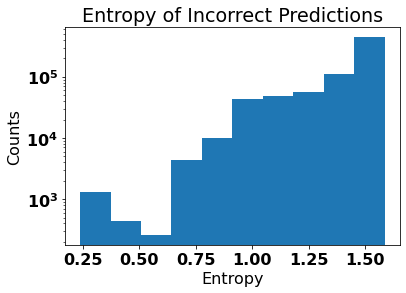

In [22]:
font = {'weight' : 'bold', 'size'   : 16}
plt.rc('font', **font)

correct = np.where( bnnPreds == buildingTypes )
incorrect = np.where( bnnPreds != buildingTypes )

plt.hist( en[incorrect] )
plt.xlabel( 'Entropy' )
plt.ylabel( 'Counts' )
plt.yscale( 'log' )
plt.title( 'Entropy of Incorrect Predictions' )

In [23]:
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 22}
plt.rc('font', **font)

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix( buildingTypes, bnnPreds, normalize='true' )

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


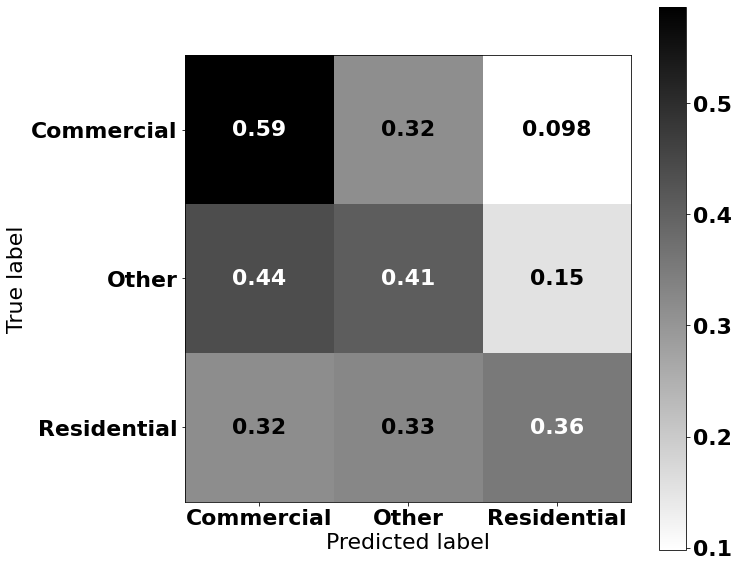

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=le.inverse_transform([0,1,2]))#rf.classes_)
disp.plot(ax=ax, cmap='gist_yarg')

In [26]:
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

print( "Balanced Accuracy:", np.round( balanced_accuracy_score(buildingTypes, bnnPreds), 4 ))
print( "Micro F1:", np.round( f1_score(buildingTypes, bnnPreds, average='micro'), 4 ))

Balanced Accuracy: 0.4501
Micro F1: 0.3731


#### Entropy-Accuracy Evaluation

In [27]:
np.min(en), np.max(en)

(0.2374104061521244, 1.5849621266579648)

In [32]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

testValues = np.arange(0.3, 1.6, 0.1)

acc = []
thr = []
pct = []

n = bnnPreds.shape[0]

for t in testValues:
    
    ixs = np.where( en <= t )
    y = buildingTypes[ixs]
    x = bnnPreds[ixs]
    
    acc.append( balanced_accuracy_score(y,x) )
    thr.append( t )
    pct.append( len(ixs[0])/n )

    print( "Threshold:", t )
    print( "Percent of predictions:", len(ixs[0])/n )
    print( "Balanced Accuracy:", np.round( balanced_accuracy_score(y,x), 4 ))
    print( "Macro F1:", np.round( f1_score(y,x, average='macro'), 4 ))
    print( "Macro Precision:", np.round( precision_score(y,x, average='macro'), 4 ))
    print( "Macro Recall:", np.round( recall_score(y,x, average='macro'), 4 ))
    print()

Threshold: 0.3
Percent of predictions: 0.03172965756320581
Balanced Accuracy: 0.3333
Macro F1: 0.3306
Macro Precision: 0.3278
Macro Recall: 0.3333

Threshold: 0.4
Percent of predictions: 0.05398129483529034
Balanced Accuracy: 0.3333
Macro F1: 0.3294
Macro Precision: 0.3256
Macro Recall: 0.3333

Threshold: 0.5
Percent of predictions: 0.061199677896432124
Balanced Accuracy: 0.3333
Macro F1: 0.3292
Macro Precision: 0.3251
Macro Recall: 0.3333

Threshold: 0.6000000000000001
Percent of predictions: 0.06651543939242426
Balanced Accuracy: 0.3333
Macro F1: 0.3291
Macro Precision: 0.325


/opt/tljh/user/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/tljh/user/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/tljh/user/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/tljh/user/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedM

Macro Recall: 0.3333

Threshold: 0.7000000000000002
Percent of predictions: 0.07208119957263383
Balanced Accuracy: 0.3333
Macro F1: 0.3289
Macro Precision: 0.3246
Macro Recall: 0.3333

Threshold: 0.8000000000000003
Percent of predictions: 0.08999514037645416
Balanced Accuracy: 0.5081
Macro F1: 0.443
Macro Precision: 0.415
Macro Recall: 0.5081

Threshold: 0.9000000000000001
Percent of predictions: 0.10808451885340954
Balanced Accuracy: 0.597
Macro F1: 0.5396
Macro Precision: 0.5283


/opt/tljh/user/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro Recall: 0.597

Threshold: 1.0000000000000002
Percent of predictions: 0.14903868927005648
Balanced Accuracy: 0.6315
Macro F1: 0.5453
Macro Precision: 0.5161
Macro Recall: 0.6315

Threshold: 1.1000000000000003
Percent of predictions: 0.20843837664012294
Balanced Accuracy: 0.5884
Macro F1: 0.5101
Macro Precision: 0.5045
Macro Recall: 0.5884

Threshold: 1.2000000000000004
Percent of predictions: 0.2573653121123924
Balanced Accuracy: 0.5621
Macro F1: 0.4659
Macro Precision: 0.4748
Macro Recall: 0.5621

Threshold: 1.3000000000000005
Percent of predictions: 0.31933691577061873
Balanced Accuracy: 0.5398
Macro F1: 0.4281
Macro Precision: 0.4498
Macro Recall: 0.5398

Threshold: 1.4000000000000004
Percent of predictions: 0.43262316163248266
Balanced Accuracy: 0.5134
Macro F1: 0.3789
Macro Precision: 0.4196
Macro Recall: 0.5134

Threshold: 1.5000000000000004
Percent of predictions: 0.566924209170829
Balanced Accuracy: 0.4899
Macro F1: 0.3388
Macro Precision: 0.4005
Macro Recall: 0.4899



(0.0, 1.0)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


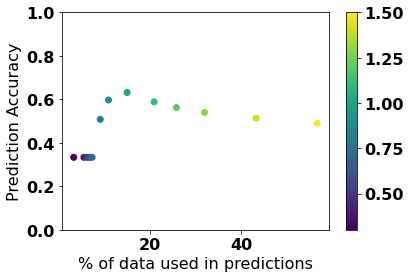

In [33]:
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 16}
plt.rc('font', **font)

plt.scatter( np.array(pct)*100., acc, c=thr )
plt.colorbar()
plt.xlabel('% of data used in predictions')
plt.ylabel('Prediction Accuracy')
plt.ylim(0,1)

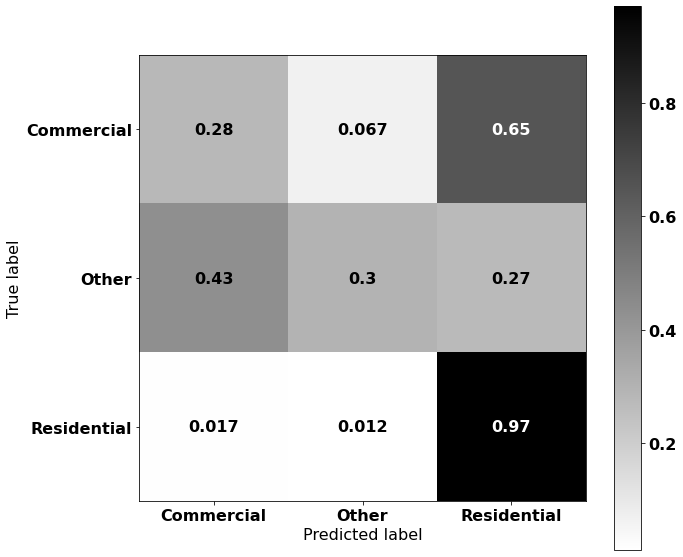

In [35]:
th = 1.0

ixs = np.where( en <= th )
y = buildingTypes[ixs]
x = bnnPreds[ixs]
    
cm = confusion_matrix( x, y, normalize='true' )

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=le.inverse_transform([0,1,2]))#rf.classes_)
disp.plot(ax=ax, cmap='gist_yarg')

In [36]:
print( "Balanced Accuracy:", np.round( balanced_accuracy_score(x,y), 4 ))
print( "Macro F1:", np.round( f1_score(x,y, average='macro'), 4 ))
print( "Macro Precision:", np.round( precision_score(x,y, average='macro'), 4 ))
print( "Macro Recall:", np.round( recall_score(x,y, average='macro'), 4 ))

Balanced Accuracy: 0.5161
Macro F1: 0.5453
Macro Precision: 0.6315
Macro Recall: 0.5161
